In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from bayesianFunction import *

In [2]:
USE_DANISH_DATA = False
if USE_DANISH_DATA:
    data = pd.read_csv('data/DanishHousingMarket.csv')
    data = df_basic_process(data)
else:
    data = pd.read_csv('data/train.csv')
    

In [3]:
if USE_DANISH_DATA: 
    data['PriceLogged'] = list(np.log(np.array(list(data.priceCash)))) # log the price so it has a normal distribution
    X = data.drop(columns=['priceCash', 'PriceLogged'], errors='ignore')  # Drop target columns
else: 
    data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
    X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# # filter out the column which are not considered important
# if not USE_DANISH_DATA: 
#     important_features = find_best_features_with_lasso(X_df=X_df, y_df=y)
#     # important_features = ["GrLivArea", "OverallQual", "YearBuilt", "TotalBsmtSF"]
#     X_df = X_df[important_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)



Linear Regression Results:
Intercept: 8.6572
Mean Squared Error: 380789677857105.4375
R-squared: -2040525688772821.5000


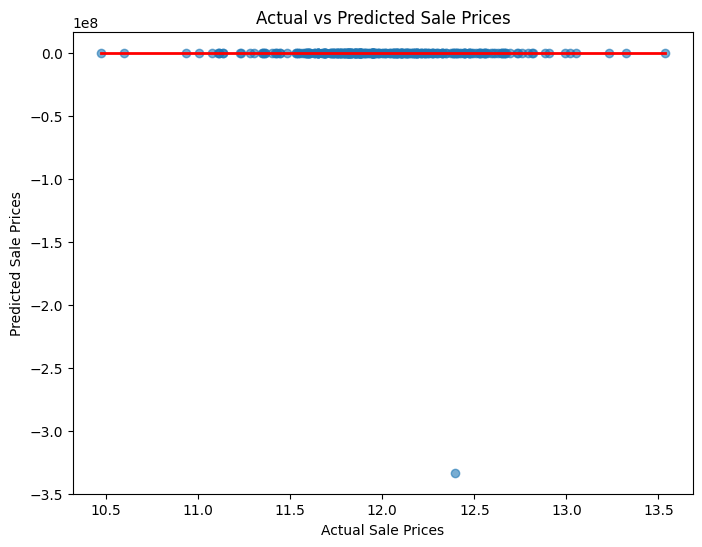

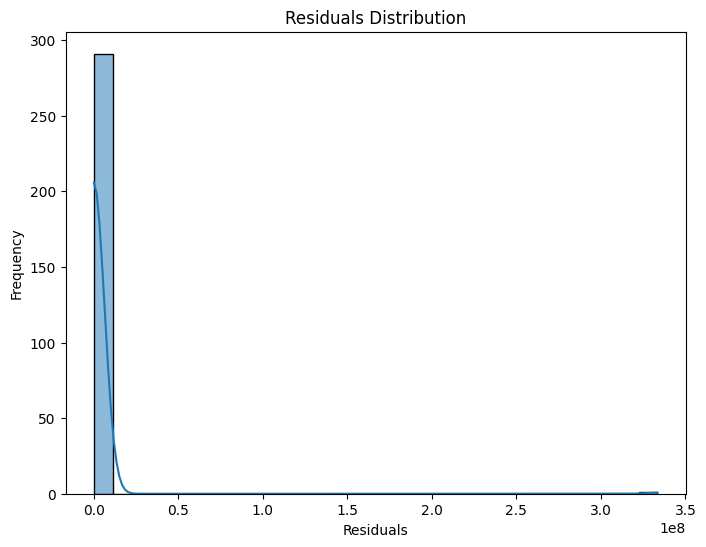


Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train the Linear Regression Model
# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# 3. Model Performance and Diagnostics
print("\nLinear Regression Results:")
print(f"Intercept: {model.intercept_:.4f}")

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# relative_error = get_relative_error(y_true=np.array(list(y_test)), y_pred=y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
# print(f"Relative Error: {relative_error}%")


# 4. Compare Predictions with Actual Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', lw=2)  # 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices')
plt.show()

# 5. Residual Diagnostics
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test for Residual Normality
residual_stat, residual_p_value = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test for Residual Normality: P-Value = {residual_p_value:.3f}")
if residual_p_value < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals are normally distributed.")

print("\nModel Diagnostics and Results Completed!")

Linear Regression Results with Log-Transformed Target:
Coefficient for 'GrLivArea': 0.0005
Intercept: 11.2468
Mean Squared Error (Log Scale): 0.0858
R-squared: 0.5402

Shapiro-Wilk Test for Residual Normality: P-Value = 0.000
Residuals are not normally distributed.

Model Diagnostics and Results Completed!

<h3>4.5 With Lasso


Cross-Validation R-squared Scores:
[0.88936985 0.84990582 0.761863   0.90877185 0.88186026]
Mean R-squared (CV): 0.8584

Lasso Regression Results:
Best Alpha: 0.001
Mean Squared Error (Log Scale): 26654.1850
R-squared: 0.9074


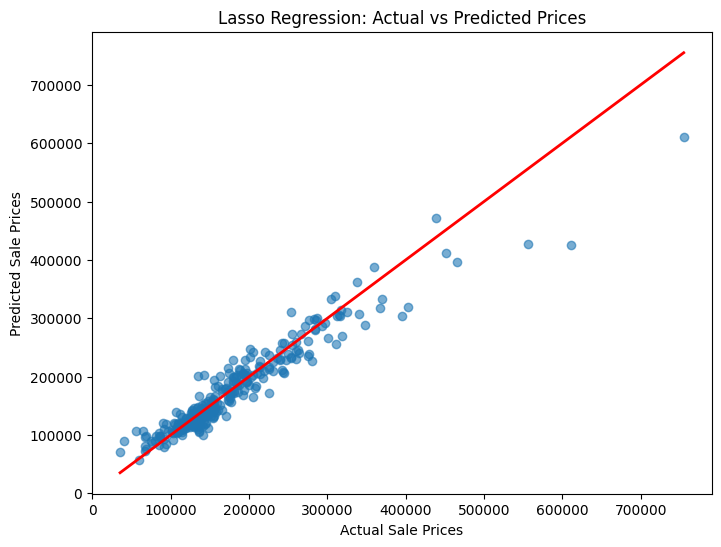


Top 10 Lasso Coefficients:
GrLivArea               0.100866
Neighborhood_StoneBr    0.092861
OverallQual             0.092068
Neighborhood_Crawfor    0.085583
Neighborhood_NridgHt    0.083775
Exterior1st_BrkFace     0.082066
CentralAir_Y            0.054231
Condition1_Norm         0.052964
Functional_Typ          0.052449
GarageCars              0.051795
dtype: float64


In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}  # Regularization strengths
lasso_model = Lasso(max_iter=10000)  # Increase iterations for convergence
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Lasso model
best_lasso = grid_search.best_estimator_

# Cross-validation for evaluation
cv_scores = cross_val_score(best_lasso, X_train, y_train, cv=5, scoring='r2')
print("\nCross-Validation R-squared Scores:")
print(cv_scores)
print(f"Mean R-squared (CV): {np.mean(cv_scores):.4f}")

# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Back-transform predictions to original scale
y_pred_lasso_original = np.round(np.exp(y_pred_lasso))  # Revert log1p transformation
y_test_original = np.round(np.exp(y_test))

# Evaluate performance
rmse_lasso = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
r2_lasso = r2_score(y_test_original, y_pred_lasso_original)
# relative_error = get_relative_error(y_true=y_test_original, y_pred=y_pred_lasso_original)

print("\nLasso Regression Results:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Mean Squared Error (Log Scale): {rmse_lasso:.4f}")
print(f"R-squared: {r2_lasso:.4f}")
# print(f"Relative Error: {relative_error}%")

# Compare predictions with actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', lw=2)  # Ideal 45-degree line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.show()

# Print top 10 non-zero coefficients
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)
important_features = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False)
top_10_coefficients = important_features.head(10)
print("\nTop 10 Lasso Coefficients:")
print(top_10_coefficients)


# Save to pickle file the important features to be used in the bayesian approach
with open("LassoImportantFeatures.pkl", "wb") as file:
    pickle.dump(list(important_features.index), file)


In [6]:
lasso_coefficients = pd.Series(best_lasso.coef_, index=X_df.columns)

# Identify dropped columns (coefficients set to zero)
dropped_columns = lasso_coefficients[lasso_coefficients == 0].index

print(len(dropped_columns))

print(f"Dropped Columns: {list(dropped_columns)}")

168
Dropped Columns: ['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'OpenPorchSF', 'MoSold', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Street_Pave', 'Alley_Pave', 'LotShape_Reg', 'LandContour_Low', 'Utilities_NoSeWa', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_CollgCr', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_Duplex', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf', 'HouseS

Lasso Coefficients:
GrLivArea      0.000269
OverallQual    0.110932
YearBuilt      0.003135
TotalBsmtSF    0.000117
dtype: float64

<h3>1. Bootstrapping Coefficients

In [59]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso
import pandas as pd

# Set up variables
n_bootstraps = 100
alpha = grid_search.best_params_['alpha']  # Confidence level = 95% (2.5% on each tail)
coefficients_bootstrap = []
important_features = list(lasso_coefficients[lasso_coefficients != 0].index)

# Bootstrapping
for i in range(n_bootstraps):
    # Resample the training data with replacement
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    
    # Ensure X_boot retains the correct column structure
    X_boot = pd.DataFrame(X_boot, columns=X_train.columns)
    
    # Train Lasso model on bootstrap sample
    lasso_model_boot = Lasso(alpha=alpha, max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    
    # Store coefficients
    coefficients_bootstrap.append(lasso_model_boot.coef_)

# Convert to DataFrame for easier analysis
coefficients_bootstrap = pd.DataFrame(coefficients_bootstrap, columns=list(X_train.columns))

# Calculate confidence intervals
lower_bounds = coefficients_bootstrap.quantile(2.5)
upper_bounds = coefficients_bootstrap.quantile(97.5)

# Print confidence intervals for each feature
print("Bootstrapped Confidence Intervals for Lasso Coefficients:")
for feature in important_features:
    print(f"{feature}: [{lower_bounds[feature]:.6f}, {upper_bounds[feature]:.6f}]")


Bootstrapped Confidence Intervals for Lasso Coefficients:
Id: [-0.008682, 0.001782]
MSSubClass: [-0.038497, -0.003717]
LotFrontage: [-0.024517, 0.013496]
LotArea: [0.005234, 0.021888]
OverallQual: [0.070219, 0.106020]
OverallCond: [0.033227, 0.058017]
YearBuilt: [0.024594, 0.073753]
YearRemodAdd: [0.011769, 0.034364]
MasVnrArea: [-0.006930, 0.006056]
BsmtUnfSF: [0.000000, 0.014080]
1stFlrSF: [0.000000, 0.017754]
GrLivArea: [0.077562, 0.144669]
BsmtFullBath: [0.010723, 0.043934]
BsmtHalfBath: [-0.002503, 0.009515]
FullBath: [0.000000, 0.025628]
HalfBath: [0.002157, 0.021700]
BedroomAbvGr: [-0.003828, 0.017422]
KitchenAbvGr: [-0.017849, 0.001019]
TotRmsAbvGrd: [0.000000, 0.035428]
Fireplaces: [0.014151, 0.031658]
GarageYrBlt: [-0.021553, 0.000462]
GarageCars: [0.011008, 0.073094]
GarageArea: [-0.000285, 0.040976]
WoodDeckSF: [0.006759, 0.023274]
EnclosedPorch: [-0.002867, 0.015155]
3SsnPorch: [0.000931, 0.012603]
ScreenPorch: [0.008383, 0.021423]
PoolArea: [-0.089866, 0.012740]
MiscVal: 

In [60]:
coefficients_bootstrap

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.004060,-0.033490,-0.011548,0.005974,0.097134,0.043918,0.025565,0.022968,0.000000,-0.000000,...,-0.0,-0.0,0.027742,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.742226e-15
1,0.002285,-0.022524,0.007726,0.015127,0.076602,0.047589,0.065473,0.022727,0.000125,0.016334,...,-0.0,0.0,0.033827,0.0,-0.000000,0.0,0.0,-0.008182,0.050564,3.496622e-02
2,-0.008859,-0.033519,-0.014416,0.013637,0.103925,0.038095,0.049819,0.010363,0.001608,-0.028457,...,-0.0,-0.0,0.000000,0.0,-0.000000,-0.0,0.0,0.000000,0.010494,4.915937e-02
3,-0.001911,-0.029225,-0.009501,0.018771,0.088532,0.046290,0.051328,0.018284,0.000000,-0.011486,...,0.0,-0.0,0.000000,0.0,-0.000000,0.0,0.0,-0.000000,0.020711,3.214061e-02
4,0.000267,-0.019491,0.006048,0.014592,0.079557,0.048705,0.058761,0.023883,0.001610,0.027703,...,-0.0,-0.0,0.000000,0.0,0.000858,0.0,0.0,0.000000,0.021148,6.276391e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.003416,-0.013915,0.004135,0.016562,0.068554,0.053484,0.058684,0.027109,-0.002435,0.007962,...,-0.0,-0.0,0.028424,0.0,-0.019610,0.0,0.0,-0.000000,0.019632,0.000000e+00
96,-0.000000,-0.009886,0.005262,0.009221,0.079337,0.056583,0.068118,0.017230,0.000000,0.021759,...,-0.0,0.0,0.004267,0.0,-0.000000,-0.0,0.0,-0.000000,0.017780,6.501104e-02
97,0.001226,-0.028697,-0.017944,0.013788,0.096281,0.039742,0.057849,0.014887,-0.003721,-0.016922,...,-0.0,-0.0,0.016388,0.0,-0.000000,0.0,0.0,-0.000000,0.019065,6.417022e-03
98,-0.000269,-0.035307,-0.013049,0.019526,0.110327,0.046627,0.058622,0.021262,-0.006739,-0.008575,...,0.0,-0.0,0.000000,0.0,-0.000000,0.0,0.0,0.000000,0.028103,3.825595e-02


In [61]:
features_coeffs_ranking = {}
for feature in coefficients_bootstrap:
    feature_coeffs = np.array(list(coefficients_bootstrap[feature]))
    features_coeffs_ranking[feature] = np.abs(np.mean(feature_coeffs))
features_coeffs_ranking = {k:v for k,v in sorted(features_coeffs_ranking.items(), key=lambda i:i[1], reverse=True)}

high_ranking_features = list(features_coeffs_ranking.keys())[:10]


In [62]:
high_ranking_features = {i:np.mean(np.array(list(coefficients_bootstrap[i]))) for i in high_ranking_features}
pd.DataFrame({'Feature':list(high_ranking_features.keys()), 'Coefficient':list(high_ranking_features.values())})

,Feature,Coefficient
0,Condition2_PosN,-0.174989
1,GrLivArea,0.107098
2,OverallQual,0.088418
3,Neighborhood_Crawfor,0.081666
4,Neighborhood_StoneBr,0.071875
5,Exterior1st_BrkFace,0.069218
6,Neighborhood_NridgHt,0.059603
7,Functional_Typ,0.052153
8,YearBuilt,0.051132
9,Condition1_Norm,0.047752


Condition2_PosN lower_bound -->  -0.9688174656246681 upper_bound --> 0.7760026441868442
GrLivArea lower_bound -->  0.23317463348224732 upper_bound --> 2.0254829351554307
OverallQual lower_bound -->  1.044101469384803 upper_bound --> 3.069380749928761
Neighborhood_Crawfor lower_bound -->  2.2856052139425205 upper_bound --> 3.9948422341812053
Neighborhood_StoneBr lower_bound -->  3.047000925312484 upper_bound --> 4.932633797470812
Exterior1st_BrkFace lower_bound -->  4.020679228272173 upper_bound --> 5.899375729788788
Neighborhood_NridgHt lower_bound -->  5.033289004878094 upper_bound --> 6.939770435807237
Functional_Typ lower_bound -->  6.146717190921149 upper_bound --> 7.8963328974376275
YearBuilt lower_bound -->  7.318621706275546 upper_bound --> 9.08088433540706
Condition1_Norm lower_bound -->  8.01527867343906 upper_bound --> 9.91246556427883


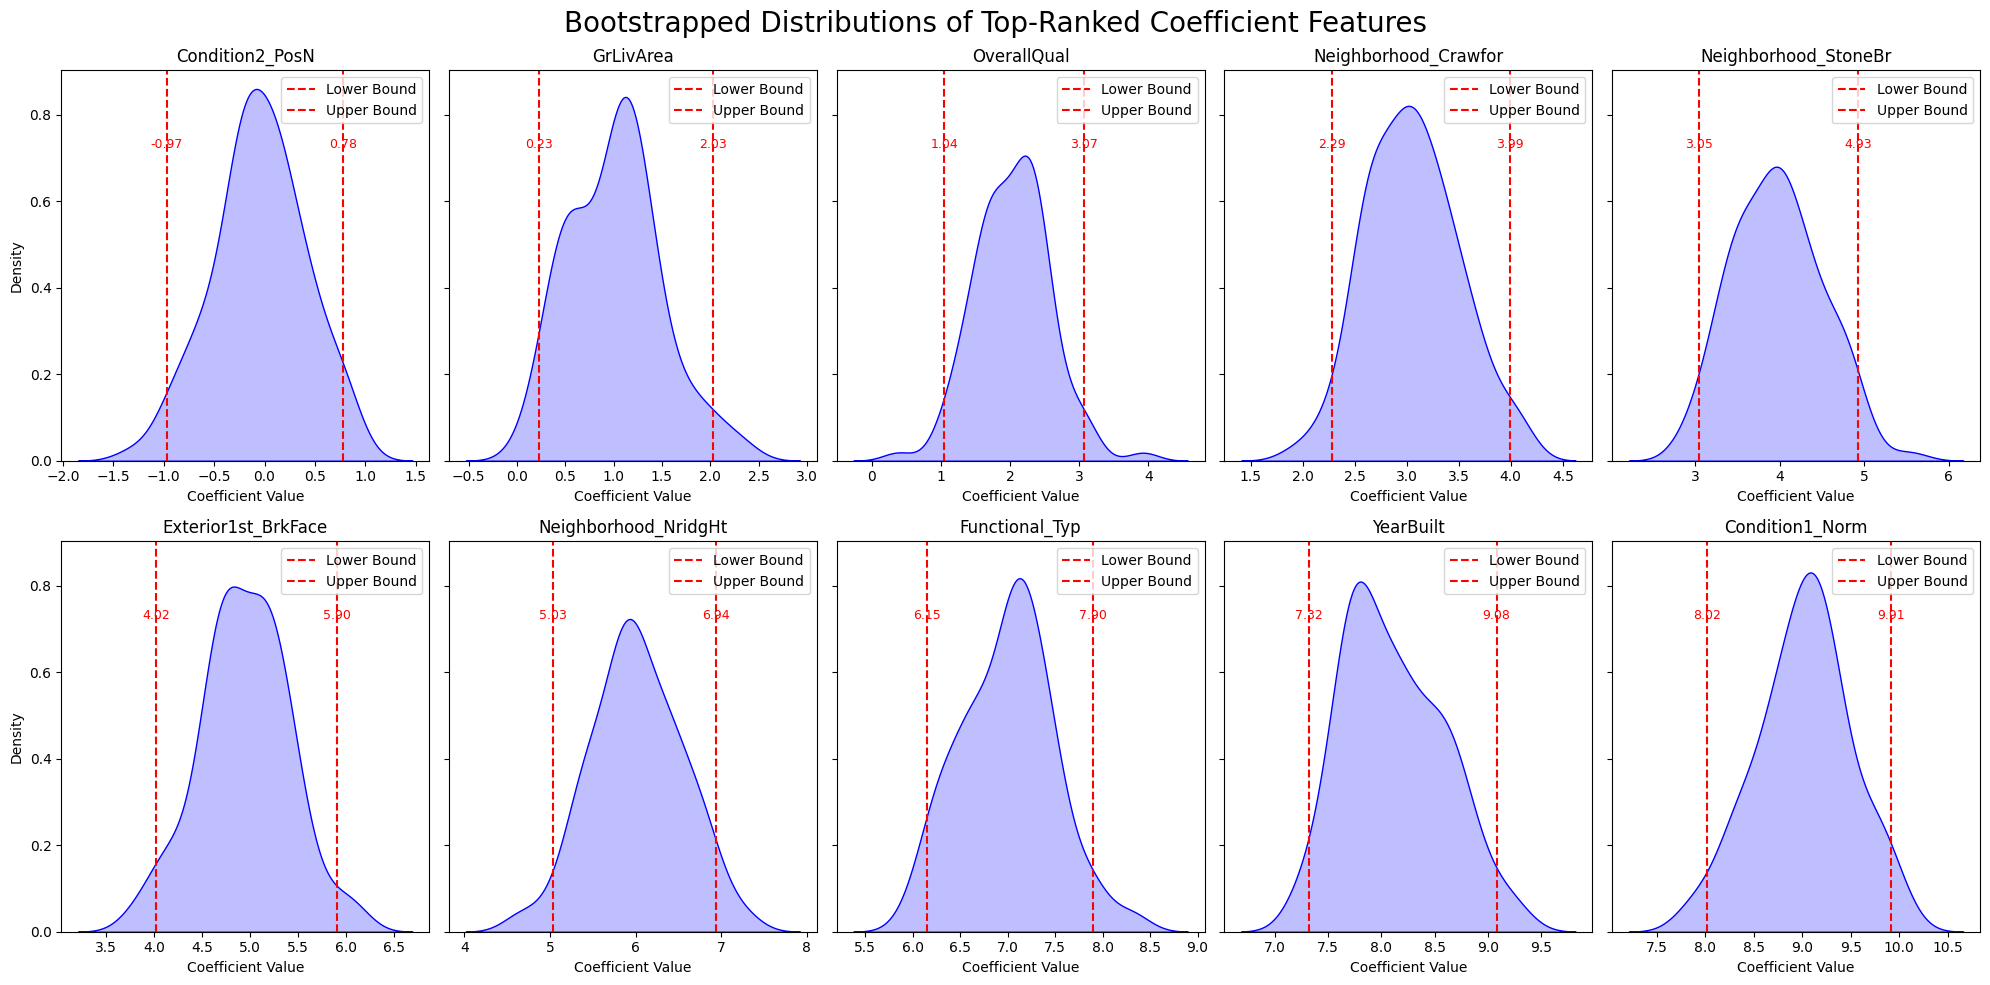

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Simulate bootstrapped coefficients for 10 features (replace with your actual data)
np.random.seed(42)
feature_names = high_ranking_features
coefficients_bootstrap = {feature: np.random.normal(loc=i, scale=0.5, size=100) for i, feature in enumerate(feature_names)}

# Plot KDEs for the coefficients
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)  # 2 rows, 5 columns
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Calculate 95% confidence interval
    lower_bound = np.percentile(coefficients_bootstrap[feature], 2.5)
    upper_bound = np.percentile(coefficients_bootstrap[feature], 97.5)
    
    print(feature, 'lower_bound --> ', lower_bound, 'upper_bound -->', upper_bound)

    ax = axes[i]
    sns.kdeplot(coefficients_bootstrap[feature], fill=True, color='blue', ax=ax)
    ax.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
    
    # Add text annotations for the confidence intervals
    ax.text(lower_bound, ax.get_ylim()[1] * 0.8, f"{lower_bound:.2f}", color='red', ha='center', fontsize=9)
    ax.text(upper_bound, ax.get_ylim()[1] * 0.8, f"{upper_bound:.2f}", color='red', ha='center', fontsize=9)
    
    ax.set_title(feature)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Density")
    ax.legend(loc='upper right')  # Add legend to each subplot

# Adjust layout to prevent overlap
fig.suptitle('Bootstrapped Distributions of Top-Ranked Coefficient Features', fontsize=20)
plt.tight_layout()
plt.show()


In [65]:
coefficients_bootstrap[feature]

array([ 9.18433665,  8.80333059,  9.01437241,  9.63922593,  9.09554953,
        9.02321827,  8.32007193,  9.37312678,  9.32274209, 10.08162736,
        8.84611088,  9.10957516,  9.12469184,  9.78872664,  8.95235223,
        9.13951076,  9.30394825,  9.09330456,  8.77678319,  9.097045  ,
        9.53681587,  8.48674235,  9.06648484,  8.64993959,  9.59752331,
        8.23840655,  8.72053908,  9.18860594,  9.78276201,  8.96712487,
        8.72240024,  9.94057853,  8.27599305,  7.90059702,  9.22000723,
        8.74897289,  8.48938359,  9.35417822,  9.12190036,  8.71796068,
        8.3598478 ,  9.43622866,  9.32510059,  8.95041207,  9.9233185 ,
        8.46495762,  8.23723741,  8.65404597,  8.97720699,  9.12166972,
        8.87938197,  9.1760277 ,  8.37423029,  9.7218823 ,  8.95892441,
        9.55864792,  9.17136267,  9.22837661,  9.28488364,  9.22385428,
        9.32136138,  9.66457627,  9.09826058,  9.35450188,  8.95513215,
        9.72005861,  8.66180385,  9.90047022,  8.97992102,  8.28

Condition2_PosN: [-0.958216, -0.000000]
GrLivArea: [0.068648, 0.145833]
OverallQual: [0.058598, 0.110189]
Neighborhood_Crawfor: [0.028378, 0.134073]
Neighborhood_StoneBr: [0.000000, 0.187647]
Exterior1st_BrkFace: [0.019097, 0.124588]
Neighborhood_NridgHt: [0.000000, 0.126877]
Functional_Typ: [0.014631, 0.094092]
YearBuilt: [0.013660, 0.075687]
Condition1_Norm: [0.026857, 0.070953]


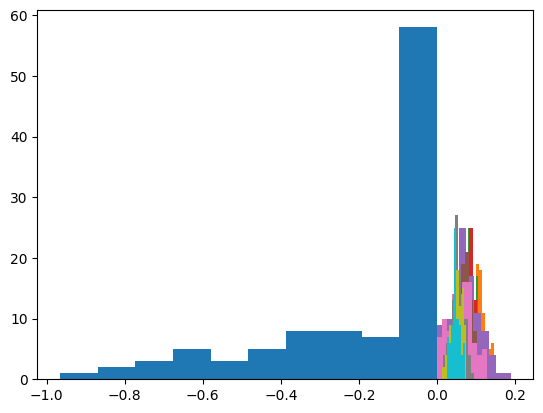

In [27]:
counter = 0
for feature in high_ranking_features:
    feature_coeffs = coefficients_bootstrap[feature]
    plt.hist(feature_coeffs)
    print(f"{feature}: [{lower_bounds[feature]:.6f}, {upper_bounds[feature]:.6f}]")
    counter += 1
    # break

Get the distribution of the coefficients for every sample, and get its paramters to use for the priors

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm

def is_normal_ks(data, alpha=0.05):
    # Test against a normal distribution
    # print(kstest(data, 'norm', args=(data.mean(), data.std())))
    stat, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    # print(stat, p, alpha)
    return p > alpha  # Returns True if data is normal


counter = 0
priors_info = {}
# Visualize the distribution for each feature's coefficients
for feature in important_features:
    # sns.histplot(coefficients_bootstrap[feature], kde=True)
    # plt.title(f"Bootstrapped Distribution for {feature}")
    # plt.xlabel("Coefficient Value")
    # plt.ylabel("Frequency")
    # plt.show()

    normal_test = is_normal_ks(np.array(list(coefficients_bootstrap[feature])), alpha=0.05)

    if normal_test:
        mean = coefficients_bootstrap[feature].mean()
        std = coefficients_bootstrap[feature].std()
        priors_info[feature] = {"mean": mean, "std": std}     
    else:
        print(f'{feature} is not normal')
        priors_info[feature] = {"mean": 0, "std": 1}        

    counter += 1

# Print priors information
for feature, stats in priors_info.items():
    print(f"{feature}: Mean={stats['mean']:.4f}, Std={stats['std']:.4f}")


import json
# save the paramters as a json file so we can use in the bayesian script
with open("priors_info.json", "w") as file:
    json.dump(priors_info, file)



Bootstrapped Confidence Intervals for Lasso Coefficients:
GrLivArea: [0.000216, 0.000331]
OverallQual: [0.088705, 0.131872]
YearBuilt: [0.002720, 0.003594]
TotalBsmtSF: [0.000016, 0.000212]

In [12]:
r2_scores = []
mse_scores = []

# Bootstrapping metrics
for i in range(n_bootstraps):
    X_boot, y_boot = resample(X_train, y_train, random_state=i)
    lasso_model_boot = Lasso(alpha=grid_search.best_params_['alpha'], max_iter=10000)
    lasso_model_boot.fit(X_boot, y_boot)
    y_pred_boot = lasso_model_boot.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred_boot))
    mse_scores.append(mean_squared_error(y_test, y_pred_boot))

# Calculate confidence intervals
r2_lower, r2_upper = np.percentile(r2_scores, [2.5, 97.5])
mse_lower, mse_upper = np.percentile(mse_scores, [2.5, 97.5])

print(f"95% CI for R-squared: [{r2_lower:.4f}, {r2_upper:.4f}]")
print(f"95% CI for MSE: [{mse_lower:.4f}, {mse_upper:.4f}]")


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.804e+00, tolerance: 1.842e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.700e+00, tolerance: 1.721e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.113e+00, toleranc

95% CI for R-squared: [0.8250, 0.8893]
95% CI for MSE: [0.0207, 0.0327]


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.664e+00, tolerance: 1.980e-02
  model = cd_fast.enet_coordinate_descent(


95% CI for R-squared: [0.8052, 0.8448]
95% CI for MSE: [0.0290, 0.0364]

<h3>GPT-Optimized

Best Alpha: 0.0016768329368110084
RMSE (Log Scale): 0.1530
RMSE (Original Scale): 28067.15


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.547e+00, tolerance: 1.781e-02
  model = cd_fast.enet_coordinate_descent(


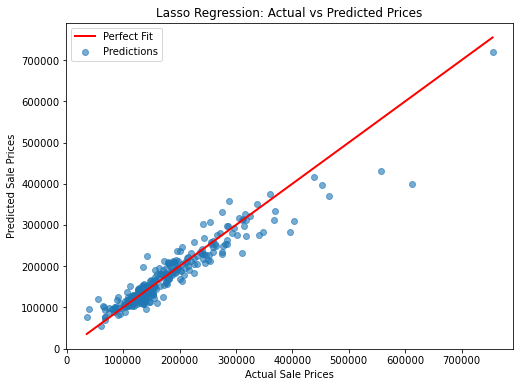

c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.109e+01, tolerance: 2.119e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+01, tolerance: 2.100e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+01, toleranc

Mean CV RMSE (Log Scale): 0.1476


c:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+01, tolerance: 2.091e-02
  model = cd_fast.enet_coordinate_descent(


In [13]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Hyperparameter Tuning with Cross-Validation
param_grid = {'alpha': np.logspace(-4, 1, 50)}  # Finer range of alpha values
lasso_model = Lasso(max_iter=10000)
grid_search = GridSearchCV(lasso_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_lasso = grid_search.best_estimator_

# Step 3: Model Performance
# Predict on test set
y_pred_lasso = best_lasso.predict(X_test)

# Evaluate RMSE on log scale
mse_lasso_log = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso_log = np.sqrt(mse_lasso_log)
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"RMSE (Log Scale): {rmse_lasso_log:.4f}")

# Back-transform predictions
y_pred_lasso_original = np.expm1(y_pred_lasso)
y_test_original = np.expm1(y_test)

# Calculate RMSE on original scale
rmse_lasso_original = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_original))
print(f"RMSE (Original Scale): {rmse_lasso_original:.2f}")

# Plot Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_lasso_original, alpha=0.6, label='Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], color='red', lw=2, label='Perfect Fit')
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.legend()
plt.show()

# Step 4: Cross-Validation Performance
cv_scores = cross_val_score(best_lasso, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"Mean CV RMSE (Log Scale): {cv_rmse.mean():.4f}")


Best Alpha: 0.0021209508879201904
RMSE (Log Scale): 0.1698
RMSE (Original Scale): 31813.14

Mean CV RMSE (Log Scale): 0.1693